!wget https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_30_monomer_library.xml

In [1]:
from lxml import etree
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import molzip
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import copy
Draw.SetComicMode = True
Draw.rdDepictor.SetPreferCoordGen(True)

In [2]:
tree = etree.parse('./chembl_30_monomer_library.xml')
root = tree.getroot()

In [3]:
monomer_list = root[0][0][:]

In [4]:
list(monomer_list[0])

[<Element {lmr}MonomerID at 0x7fa9da42fd20>,
 <Element {lmr}MonomerSmiles at 0x7fa9da42fd70>,
 <Element {lmr}MonomerMolFile at 0x7fa9da42fdc0>,
 <Element {lmr}MonomerType at 0x7fa9da42fe10>,
 <Element {lmr}PolymerType at 0x7fa9da42fe60>,
 <Element {lmr}NaturalAnalog at 0x7fa9da42feb0>,
 <Element {lmr}MonomerName at 0x7fa9da42ff00>,
 <Element {lmr}Attachments at 0x7fa9da42ff50>]

In [5]:
mols = []
for m in monomer_list:
    mol = Chem.MolFromSmiles(m[1].text)
    mol.SetProp('Type', m[3].text)
    mols.append(mol)

In [6]:
len(mols)

2851

In [7]:
def combine_fragments(m1, m2):
    m1 = Chem.Mol(m1)
    m2 = Chem.Mol(m2)
    for atm in m1.GetAtoms():
        if atm.HasProp('atomLabel') and atm.GetProp('atomLabel') == '_R2':
            atm.SetAtomMapNum(1)
    for atm in m2.GetAtoms():
        if atm.HasProp('atomLabel') and atm.GetProp('atomLabel') == '_R1':
            atm.SetAtomMapNum(1)
    return molzip(m1, m2)

def make_peptide(monomerlist):
    monomerlist = copy.deepcopy(monomerlist)
    for idx, monomer in enumerate(monomerlist):
        if Chem.MolToSmiles(monomer).count("*") == 1:
            continue
        if idx==0:
            res = monomer
        else:
            res = combine_fragments(res, monomer)
    return res

def cap_terminal(m):
    m = Chem.Mol(m)
    n_term = Chem.MolFromSmiles('CC(=O)[*:1]')
    c_term = Chem.MolFromSmiles('CO[*:2]')
    for atm in m.GetAtoms():
        if atm.HasProp('atomLabel') and atm.GetProp('atomLabel') == '_R1':
            atm.SetAtomMapNum(1)
        if atm.HasProp('atomLabel') and atm.GetProp('atomLabel') == '_R2':
            atm.SetAtomMapNum(2)
    res = molzip(m, n_term)
    res = molzip(res, c_term)
    return res

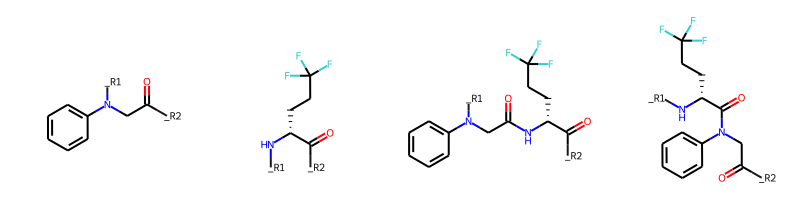

In [8]:
m1 = combine_fragments(mols[1], mols[2])
m2 = combine_fragments(mols[2], mols[1])
Draw.MolsToGridImage([mols[1], mols[2], m1, m2], molsPerRow=4)

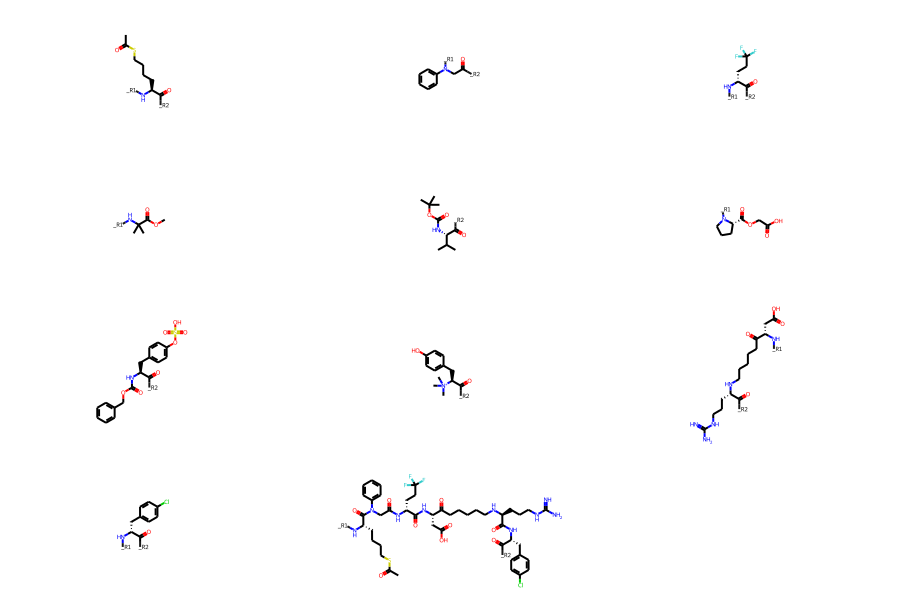

In [9]:
m3 = make_peptide(mols[:10])
Draw.MolsToGridImage(mols[:10]+[m3], molsPerRow=3, subImgSize=(300,150))

RDKit WARNING: [16:28:06] Incomplete atom labelling, cannot make bond


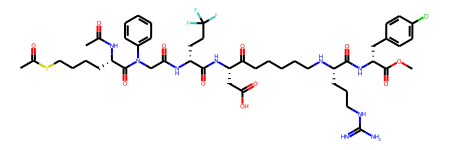

In [10]:
cap_terminal(m3)